In [3]:
!nvidia-smi
!pip install ultralytics
!pip install --upgrade pip
!yolo checks

Thu Jun  8 15:10:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   42C    P8    N/A /  N/A |      6MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import libraries and initialize needed variables

In [1]:
import torch
import os
import cv2
import wandb

from ultralytics import YOLO
from PIL import Image
from collections import Counter

wandb.init(project="YoloObjectDetection", name="YOLO_first_training")

train_path = '/home/himars/Programming/datasets/KITTI/training/'
test_path = '/home/himars/Programming/datasets/KITTI/testing/'

torch.cuda.is_available()
torch.cuda.device(device=0)
torch.cuda.get_device_name(device=0)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: trybushenko. Use `wandb login --relogin` to force relogin


'NVIDIA GeForce GTX 1050'

### View the images of KITTI dataset

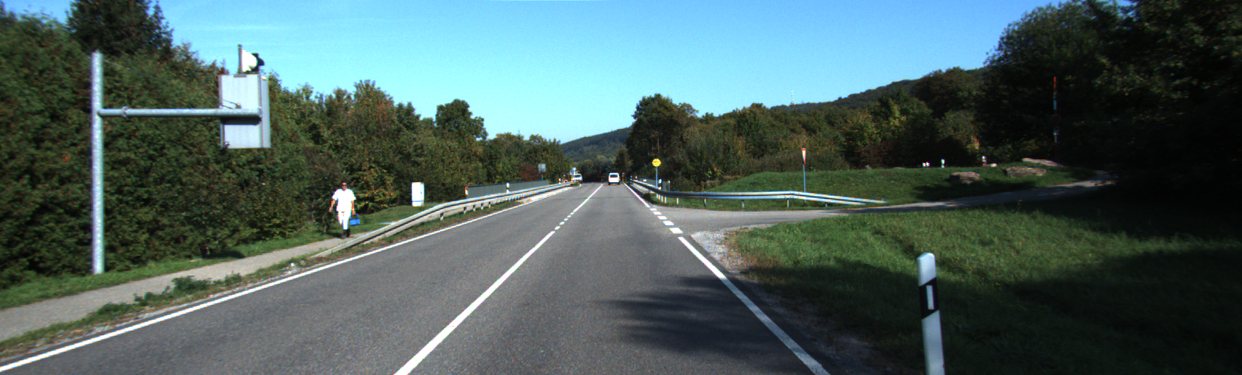

In [2]:
Image.open('/home/himars/Programming/datasets/KITTI/training/images/000005.png')

### Observe shape of images and classes available in the label file

In [3]:
cv2.imread('/home/himars/Programming/datasets/KITTI/training/images/000005.png').shape
cv2.imread('/home/himars/Programming/datasets/coco128/images/train2017/000000000025.jpg').shape

(426, 640, 3)

In [77]:
labels = []

for label in os.listdir(f'/home/himars/Programming/datasets/KITTI/training/new_labels'):
    with open(f'/home/himars/Programming/datasets/KITTI/training/new_labels/{label}') as f:
        labels += [i.split()[0] for i in f.readlines()]

# compose number of the class according to its frequency in the dataset. Order is descending
classes_kitti = sorted(list(Counter(labels).items()), key=lambda x: x[1], reverse=True)
classes_mapping = {classes_kitti[i][0] : i for i in range(len(classes_kitti))}

del(labels)

from pprint import pprint

pprint(classes_mapping)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6}


### Normalize images and change the input format of labels for YOLOv5 model

In [10]:
darknet = 'darknet_label_2'
testing = 0

if darknet not in os.listdir(train_path):
    os.mkdir(f'{train_path}{darknet}')
    train_label = f'{train_path}label_2'

    for label in os.listdir(train_label):
        with open(f'{train_label}/{label}') as f:
            
            darknet_format = """"""
            image = cv2.imread(f'{train_path}image_2/{label.split(".")[0]}.png')
            image_height, image_width = image.shape[:2]

            for line in f.readlines():
                line = line.split()

                # convert to darknet format
                class_type = classes_mapping[line[0]]
                xmin, ymin, xmax, ymax = line[4:8]
                x_center = (float(xmin) + float(xmax)) / 2.0
                y_center = (float(ymin) + float(ymax)) / 2.0
                width = float(xmax) - float(xmin)
                height = float(ymax) - float(ymin)

                # normalize values
                x_center, width = [i / image_width for i in [x_center, width]]
                y_center, height = [i / image_height for i in [y_center, height]]

                # output darknet format
                darknet_format += f'{class_type} {x_center} {y_center} {width} {height}\n'
            
            # delete the last newline character
            darknet_format = darknet_format[:-1]
            with open(f'{train_path}{darknet}/{label}', mode='w') as darknet_file:
                darknet_file.write(darknet_format)

if testing:
    os.rmdir(train_path + darknet)

In [11]:
os.rename(f'{train_path}{darknet}', f'{train_path}labels')
os.rename(f'{train_path}image_2', f'{train_path}images')
os.rename(f'{train_path}label_2', '/home/himars/Programming/datasets/KITTI/zips/label_2')

### Break down images on train and test directories

In [39]:
import numpy as np

test_files = []
while len(test_files) != int(np.floor(len(os.listdir('/home/himars/Programming/datasets/KITTI/training/images/')) * 0.2)):
    element = np.random.choice(os.listdir('/home/himars/Programming/datasets/KITTI/training/images/'))
    if element not in test_files:
        test_files.append(element)

print(test_files)

['006633.png', '002955.png', '006306.png', '006328.png', '003885.png', '007422.png', '006922.png', '004549.png', '004804.png', '006072.png', '006166.png', '003014.png', '001181.png', '006619.png', '005361.png', '002588.png', '002823.png', '000386.png', '003545.png', '002905.png', '006026.png', '000738.png', '003801.png', '001500.png', '006732.png', '004877.png', '001564.png', '004102.png', '000908.png', '003964.png', '006459.png', '006389.png', '000907.png', '006794.png', '003245.png', '005282.png', '005058.png', '004366.png', '002753.png', '003533.png', '002883.png', '006494.png', '006271.png', '004780.png', '002689.png', '001753.png', '001076.png', '004425.png', '000826.png', '005669.png', '002250.png', '004336.png', '002408.png', '005034.png', '003843.png', '000282.png', '000394.png', '001203.png', '001417.png', '003788.png', '007269.png', '002091.png', '001844.png', '001547.png', '006070.png', '004829.png', '004398.png', '001160.png', '002378.png', '001613.png', '002926.png', '0050

In [41]:
import numpy as np

for file in test_files:
    file_name = file.split('.')[0]
    os.rename(f'/home/himars/Programming/datasets/KITTI/training/images/{file}', 
            f'/home/himars/Programming/datasets/KITTI/validation/images/{file}')
    os.rename(f'/home/himars/Programming/datasets/KITTI/training/labels/{file_name}.txt', 
            f'/home/himars/Programming/datasets/KITTI/validation/labels/{file_name}.txt')
    
print(len(os.listdir(f'/home/himars/Programming/datasets/KITTI/validation/images/')))
    

1496


### Drop DontCare and Misc class in order to detect road objects

In [55]:
classes_mapping

{'Car': 0,
 'DontCare': 1,
 'Pedestrian': 2,
 'Van': 3,
 'Cyclist': 4,
 'Truck': 5,
 'Misc': 6,
 'Tram': 7,
 'Person_sitting': 8}

### Make right indexation of classes in labels

In [ ]:
valid_path = f'/home/himars/Programming/datasets/KITTI/validation/'

try:
    os.mkdir(f'{valid_path}/new_labels/')
except FileExistsError:
    pass

for file in os.listdir(f'{valid_path}/labels/'):
    with open(f'{valid_path}/labels/{file}') as f:
        with open(f'{valid_path}/new_labels/{file}', mode='w') as c:
            new_labels = [ifile for ifile in f.readlines() if ifile.split()[0] not in ['1', '6']]
            labels = []
            for cur_label in new_labels:
                cur_class = int(cur_label[0])
                cur_label = list(cur_label)

                if cur_class > 1 and cur_class < 6:
                    cur_label[0] = str(cur_class - 1)
                elif cur_class > 6:
                    cur_label[0] = str(cur_class - 2)

                labels.append(''.join(cur_label))
            c.write(''.join(labels))


### Format yaml configuration file needed for training 

In [ ]:
content = """
# Ultralytics YOLO 🚀, GPL-3.0 license
# KITTI dataset https://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=2d by  Karlsruhe Institute of Technology and Toyota Technological Institute at Chicago
# Example usage: yolo train data=kitti.yaml
# parent
# ├── ultralytics
# └── datasets
#     └── KITTI 


# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: ../datasets/KITTI  # dataset root dir
train: training/images  # train images (relative to 'path') 
val: validation/images  # val images (relative to 'path') 
test:  testing/images # test images (optional)

# Classes
names:
  0: Car
  1: Pedestrian
  2: Van
  3: Cyclist
  4: Truck
  5: Tram
  6: Person_sitting
  """

with open('kitti.yaml') as f:
    f.write(content)

### Train the model (all files applied for training is saved in runs/train/exp2 dir)

In [ ]:
!python train.py --data kitti.yaml --weights yolov5n.pt --epochs 155 --img 640 --batch-size 16 

### Validate the model (all files applied for validation is saved in runs/val dir)

In [ ]:
!python val.py --weights /home/himars/Programming/yolov5/runs/train/exp2/weights/best.pt --data kitti.yaml --img 640 --half

### Export and quantize the model to tflite format needed for android object detection application 
all files applied for exporting is saved in runs/train/exp2/weights/ dir

In [ ]:
!python export.py --weights /home/himars/Programming/yolov5/runs/train/exp2/weights/best.pt --include tflite --int8